In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from imblearn.over_sampling import SMOTE, SMOTENC
from collections import Counter

df = pd.read_csv('final.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36330 entries, 0 to 36329
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   icustay_id                   36330 non-null  int64  
 1   day_28_flag                  36330 non-null  int64  
 2   icu_exp_flag                 36330 non-null  int64  
 3   day_28_after_discharge_flag  36330 non-null  int64  
 4   ethnicity                    36330 non-null  object 
 5   gender                       36330 non-null  object 
 6   age                          36330 non-null  float64
 7   length_of_stay               36330 non-null  float64
 8   service_type                 36330 non-null  object 
 9   weight                       36330 non-null  float64
 10  height                       36330 non-null  float64
 11  sofa                         36330 non-null  int64  
 12  DiasBP                       36330 non-null  float64
 13  HeartRate       

In [2]:
id_col = 'icustay_id'

target_col = 'day_28_after_discharge_flag'

#20 numerical columns
numerical_cols = ['age', 'length_of_stay', 'sofa', 'DiasBP', 'HeartRate', 'MAP', 'SpO2',
                 'SysBP', 'Temperature', 'BUN', 'CHLORIDE', 'CREATININE', 'HEMOGLOBIN', 'PLATELET', 'POTASSIUM',
                 'SODIUM', 'TOTALCO2', 'WBC', 'bmi', 'eGFR']

#2 categorical columns
categorical_cols = ['gender', 'service_type']

In [3]:
# combine the functions above
# check categorical columns
def explore_categorical_columns(df,categorical_cols):
    nunique_values = []
    na_values = []
    for col in categorical_cols:
        nunique_values.append(df[col].nunique())
        na_values.append(len(df.loc[df[col].isna()]))
    df_stats_categorical = pd.DataFrame(list(zip(categorical_cols,nunique_values,na_values)),columns=['Column_Name','#Unique_Values','#Null_Value'])
    df_null = df_stats_categorical[df_stats_categorical['#Null_Value']>0]
    df_unique_value = df_stats_categorical[df_stats_categorical['#Unique_Values'] == 1]
    if len(df_null) > 0:
        print('Columns with Null value: %s'%(str(df_null['Column_Name'])))
    else:
        print('There is no Null values in the categorical columns')
    if len(df_unique_value) > 0:
        print('Columns with only 1 unique value: %s'%(str(list(df_unique_value['Column_Name']))))
    else:
        print('All categorical columns have more than 1 value.')
        
#check numerical columns
def explore_numerical_columns(df,numerical_cols):
    na_values = []
    for col in numerical_cols:
        na_values.append(len(df.loc[df[col].isna()]))
    df_stats_numerical = pd.DataFrame(list(zip(numerical_cols,na_values)),columns=['Column_Name','#Null_Value'])
    df_null = df_stats_numerical[df_stats_numerical['#Null_Value']>0]
    df_stats = df[numerical_cols].describe().T
    df_unique_value = df_stats[df_stats['std']==0]
    
    if len(df_null) > 0:
        print('Columns with Null value: %s'%(str(df_null['Column_Name'])))
    else:
        print('There is no Null values in the numerical columns')
    
    if len(df_unique_value) > 0:
        print('Columns with only 1 unique value: %s'%(str(list(df_unique_value.index))))
    else:
        print('All numerical columns have more than 1 value. \n')

#check categorical columns
print('Categorical_Columns'.center(50,"*"))
explore_categorical_columns(df,categorical_cols)
print('Numerical_Columns'.center(50,"*"))
#check numerical columns
explore_numerical_columns(df,numerical_cols)

***************Categorical_Columns****************
There is no Null values in the categorical columns
All categorical columns have more than 1 value.
****************Numerical_Columns*****************
There is no Null values in the numerical columns
All numerical columns have more than 1 value. 



In [4]:
# Check target variable
df[target_col].unique()

array([0, 1])

In [5]:
# Check class imbalance
df[target_col].value_counts()

0    33746
1     2584
Name: day_28_after_discharge_flag, dtype: int64

In [6]:
df_features = pd.concat([df[numerical_cols], df[categorical_cols]],axis=1)
df_labels = df[target_col]

# Random Forest with SMOTE-NC

In [7]:
# Baseline Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, recall_score, confusion_matrix, roc_curve, auc
from statistics import mean, stdev

oversample = SMOTENC(categorical_features=[20, 21, 22, 23, 24, 25, 26])
testscore = []
recall = []
auc = []

for i in range(30):
    # Split the data into train and test (75% - 25%)
    train_x, test_x, y_train, y_test = train_test_split(df_features,df_labels,test_size=0.25,random_state=i)

    # Preprocessing
    numerical_train_x = train_x[numerical_cols].reset_index(drop=True)
    categorical_train_x = pd.get_dummies(train_x[[var for var in categorical_cols]]).reset_index(drop=True)
    X_train = pd.concat([numerical_train_x, categorical_train_x],axis=1)
    numerical_test_x = test_x[numerical_cols].reset_index(drop=True)
    categorical_test_x = pd.get_dummies(test_x[[var for var in categorical_cols]]).reset_index(drop=True)
    X_test = pd.concat([numerical_test_x, categorical_test_x],axis=1)

    # Modelling
    X, y = oversample.fit_resample(X_train, y_train)

    rfc = RandomForestClassifier()
    rfc.fit(X, y)
    
    # test_accuracy_base
    testscore.append(rfc.score(X_test,y_test))
    y_true_base, y_pred_base = y_test , rfc.predict(X_test)
    
    # recall_base 
    recall.append(recall_score(y_true_base, y_pred_base))
    
    probs_base = rfc.predict_proba(X_test)
    preds_base = probs_base[:,1]
    fpr_base, tpr_base, threshold = metrics.roc_curve(y_true_base, preds_base)
    
    # roc_auc_base 
    auc.append(metrics.auc(fpr_base, tpr_base))

print("Test set score: {0:.3f} +/- {1:.3f}".format(mean(testscore), stdev(testscore)))
print("Recall: {0:.3f} +/- {1:.3f}".format(mean(recall), stdev(recall)))
print("AUC: {0:.3f} +/- {1:.3f}".format(mean(auc), stdev(auc)))

Test set score: 0.909 +/- 0.002
Recall: 0.199 +/- 0.013
AUC: 0.809 +/- 0.007


# Hyperparameter Tuning - SMOTE-NC

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, recall_score, confusion_matrix, roc_curve, auc
from statistics import mean, stdev
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
import time

start_time = time.time()

max_depth = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
oversample = SMOTENC(categorical_features=[20, 21, 22, 23, 24])

test_total = []
recall_total = []
auc_total = []

for i in range(30):
    test = []
    recall = []
    auc = []
    
    # Split the data into train and test (75% - 25%)
    train_x, test_x, y_train, y_test = train_test_split(df_features,df_labels,test_size=0.25,random_state=i)

    # Preprocessing
    numerical_train_x = train_x[numerical_cols].reset_index(drop=True)
    categorical_train_x = pd.get_dummies(train_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
    X_train = pd.concat([numerical_train_x, categorical_train_x],axis=1)
    numerical_test_x = test_x[numerical_cols].reset_index(drop=True)
    categorical_test_x = pd.get_dummies(test_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
    X_test = pd.concat([numerical_test_x, categorical_test_x],axis=1)

    # Modelling
    X, y = oversample.fit_resample(X_train, y_train)

    for d in max_depth:
        rfc = RandomForestClassifier(max_depth = d)
        rfc.fit(X, y)
    
        # test_accuracy
        test.append(rfc.score(X_test,y_test))
        y_true_base, y_pred_base = y_test , rfc.predict(X_test)
    
        # recall
        recall.append(recall_score(y_true_base, y_pred_base))
    
        probs_base = rfc.predict_proba(X_test)
        preds_base = probs_base[:,1]
        fpr_base, tpr_base, threshold = metrics.roc_curve(y_true_base, preds_base)
    
        # roc_auc
        auc.append(metrics.auc(fpr_base, tpr_base))
    
    test_total.append(test)
    recall_total.append(recall)
    auc_total.append(auc)

test_total = list(zip(*test_total))
recall_total = list(zip(*recall_total))
auc_total = list(zip(*auc_total))

test_mean = [mean(x) for x in test_total]
recall_mean = [mean(x) for x in recall_total]
auc_mean = [mean(x) for x in auc_total]

print('Time taken for training the model: '+ str(time.time() - start_time))

Time taken for training the model: 3544.813205242157


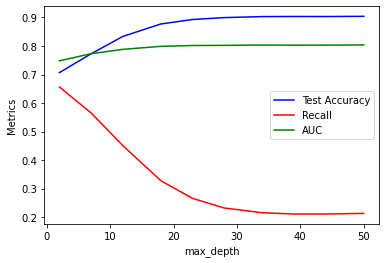

In [9]:
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt

plt.plot(max_depth, test_mean, color='b', label='Test Accuracy')
plt.plot(max_depth, recall_mean, color='r', label='Recall')
plt.plot(max_depth, auc_mean, color='g', label='AUC')
plt.legend(loc = 'center right')
plt.ylabel('Metrics')
plt.xlabel('max_depth')
plt.show()

In [13]:
# RFC - Randomised Tuning

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, recall_score, confusion_matrix, roc_curve, auc, make_scorer, accuracy_score
from statistics import mean, stdev
import seaborn as sns

oversample = SMOTENC(categorical_features=[20, 21, 22, 23, 24])

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
max_features = ['log2', 'sqrt']
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 30, num = 10)]
bootstrap = [True, False]

# Split the data into train and test (75% - 25%)
train_x, test_x, y_train, y_test = train_test_split(df_features,df_labels,test_size=0.25)

# Preprocessing
numerical_train_x = train_x[numerical_cols].reset_index(drop=True)
categorical_train_x = pd.get_dummies(train_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
X_train = pd.concat([numerical_train_x, categorical_train_x],axis=1)
numerical_test_x = test_x[numerical_cols].reset_index(drop=True)
categorical_test_x = pd.get_dummies(test_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
X_test = pd.concat([numerical_test_x, categorical_test_x],axis=1)

# Modelling
X, y = oversample.fit_resample(X_train, y_train)

rfc = RandomForestClassifier()
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

scorers = {
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

rfc_rdm = RandomizedSearchCV(rfc, param_dist, scoring = scorers, refit = 'recall_score', n_iter = 100, cv = 5, verbose = 1, n_jobs=-1)

rfc_rdm.fit(X, y)

rfc_df = pd.DataFrame(rfc_rdm.cv_results_).sort_values(by=['rank_test_recall_score', 'rank_test_accuracy_score']).reset_index(drop=True)
rfc_df = rfc_df[['param_min_samples_split', 'param_min_samples_leaf', 'param_max_features', 'param_n_estimators', 'param_bootstrap',
                 'mean_test_recall_score', 'std_test_recall_score', 'mean_test_accuracy_score', 'std_test_accuracy_score']]

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 31.2min finished


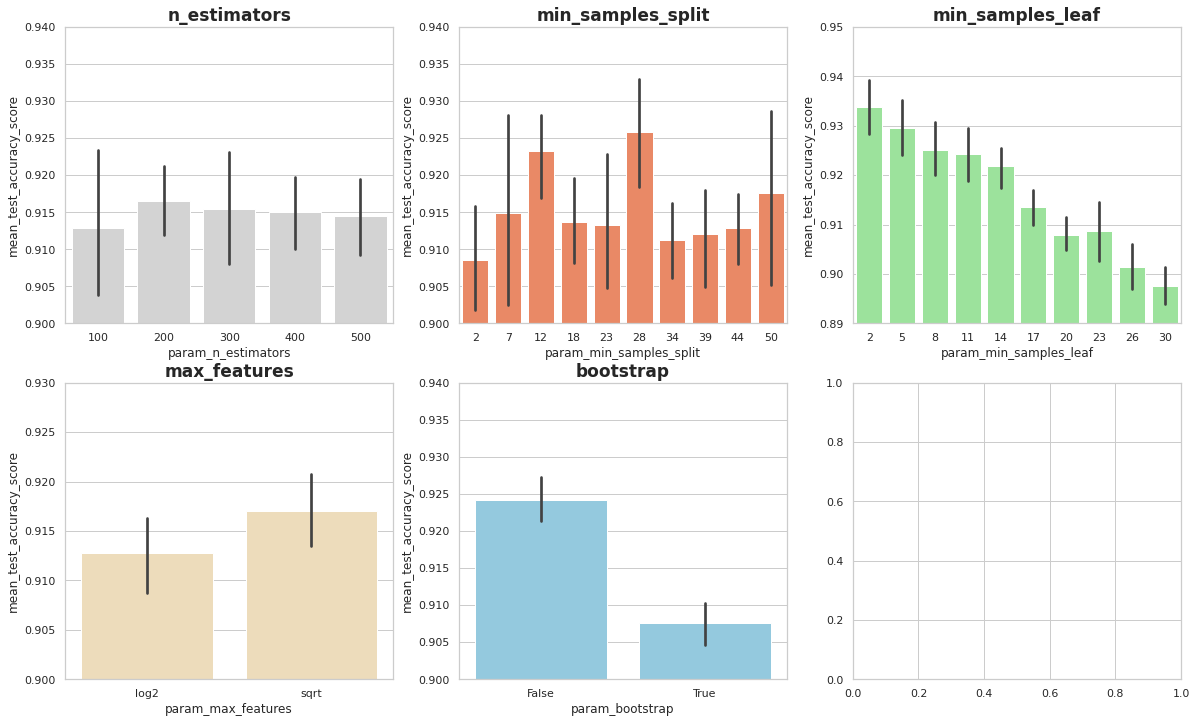

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 1)
fig.set_size_inches(20,12)
sns.barplot(x='param_n_estimators', y='mean_test_accuracy_score', data=rfc_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.9,.94]),axs[0,0].set_title(label = 'n_estimators', size=17, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_accuracy_score', data=rfc_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.9,.94]),axs[0,1].set_title(label = 'min_samples_split', size=17, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_accuracy_score', data=rfc_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.89,.95]),axs[0,2].set_title(label = 'min_samples_leaf', size=17, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_accuracy_score', data=rfc_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.9,.93]),axs[1,0].set_title(label = 'max_features', size=17, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_accuracy_score', data=rfc_df, ax=axs[1,1], color='skyblue')
axs[1,1].set_ylim([.9,.94]),axs[1,1].set_title(label = 'bootstrap', size=17, weight='bold')
plt.show()

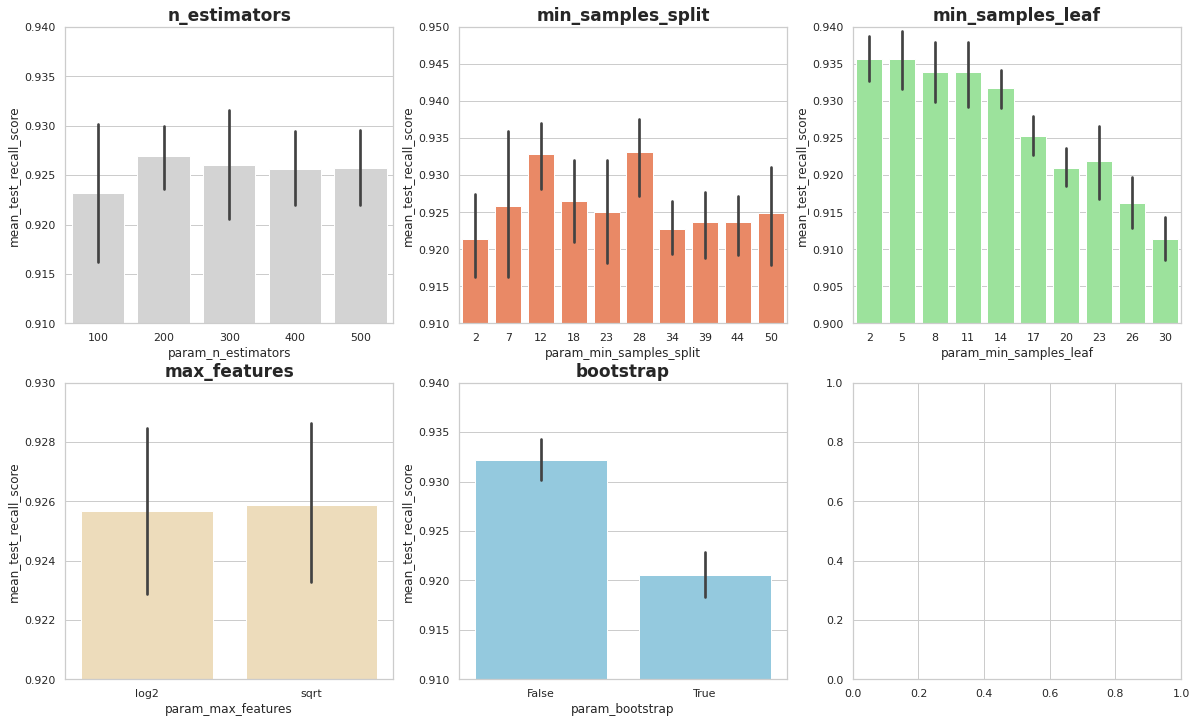

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 1)
fig.set_size_inches(20,12)
sns.barplot(x='param_n_estimators', y='mean_test_recall_score', data=rfc_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.91,.94]),axs[0,0].set_title(label = 'n_estimators', size=17, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_recall_score', data=rfc_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.91,.95]),axs[0,1].set_title(label = 'min_samples_split', size=17, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_recall_score', data=rfc_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.9,.94]),axs[0,2].set_title(label = 'min_samples_leaf', size=17, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_recall_score', data=rfc_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.92,.93]),axs[1,0].set_title(label = 'max_features', size=17, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_recall_score', data=rfc_df, ax=axs[1,1], color='skyblue')
axs[1,1].set_ylim([.91,.94]),axs[1,1].set_title(label = 'bootstrap', size=17, weight='bold')
plt.show()

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, recall_score, confusion_matrix, roc_curve, auc
from statistics import mean, stdev
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

feats = {}
ds = []
d = {}
testscore = []
recall = []
auc = []

oversample = SMOTENC(categorical_features=[20, 21, 22, 23, 24])
n_estimators = [200]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(start = 2, stop = 5, num = 4)]
min_samples_split = [27,28,29]
min_samples_leaf = [2,3,4]
bootstrap = [False]

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

for i in range(30):
    # Split the data into train and test (75% - 25%)
    train_x, test_x, y_train, y_test = train_test_split(df_features,df_labels,test_size=0.25,random_state=i)

    # Preprocessing
    numerical_train_x = train_x[numerical_cols].reset_index(drop=True)
    categorical_train_x = pd.get_dummies(train_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
    X_train = pd.concat([numerical_train_x, categorical_train_x],axis=1)
    numerical_test_x = test_x[numerical_cols].reset_index(drop=True)
    categorical_test_x = pd.get_dummies(test_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
    X_test = pd.concat([numerical_test_x, categorical_test_x],axis=1)

    # Modelling
    X, y = oversample.fit_resample(X_train, y_train)
    rfc = RandomForestClassifier()

    gs_rfc = GridSearchCV(rfc, param_dist, cv = 5, verbose = 1, n_jobs=-1)
    gs_rfc.fit(X, y)
    rfc_gs = gs_rfc.best_estimator_.fit(X, y)
    
    # coefficients
    ds.append(dict(zip(X_train.columns.tolist(), gs_rfc.best_estimator_.feature_importances_)))
    
    # test_accuracy_base
    testscore.append(rfc_gs.score(X_test,y_test))
    y_true_base, y_pred_base = y_test , rfc_gs.predict(X_test)
    
    # recall_base 
    recall.append(recall_score(y_true_base, y_pred_base))
    
    probs_base = rfc_gs.predict_proba(X_test)
    preds_base = probs_base[:,1]
    fpr_base, tpr_base, threshold = metrics.roc_curve(y_true_base, preds_base)
    
    # roc_auc_base 
    auc.append(metrics.auc(fpr_base, tpr_base))

d1 = ds[0]
for k in d1.keys():
    d[k] = tuple(d[k] for d in ds)

for feature, importance in d.items():
    feats[feature] = mean(importance)  
    
print("Test set score: {0:.3f} +/- {1:.3f}".format(mean(testscore), stdev(testscore)))
print("Recall: {0:.3f} +/- {1:.3f}".format(mean(recall), stdev(recall)))
print("AUC: {0:.3f} +/- {1:.3f}".format(mean(auc), stdev(auc)))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Test set score: 0.742 +/- 0.009
Recall: 0.615 +/- 0.026
AUC: 0.763 +/- 0.008


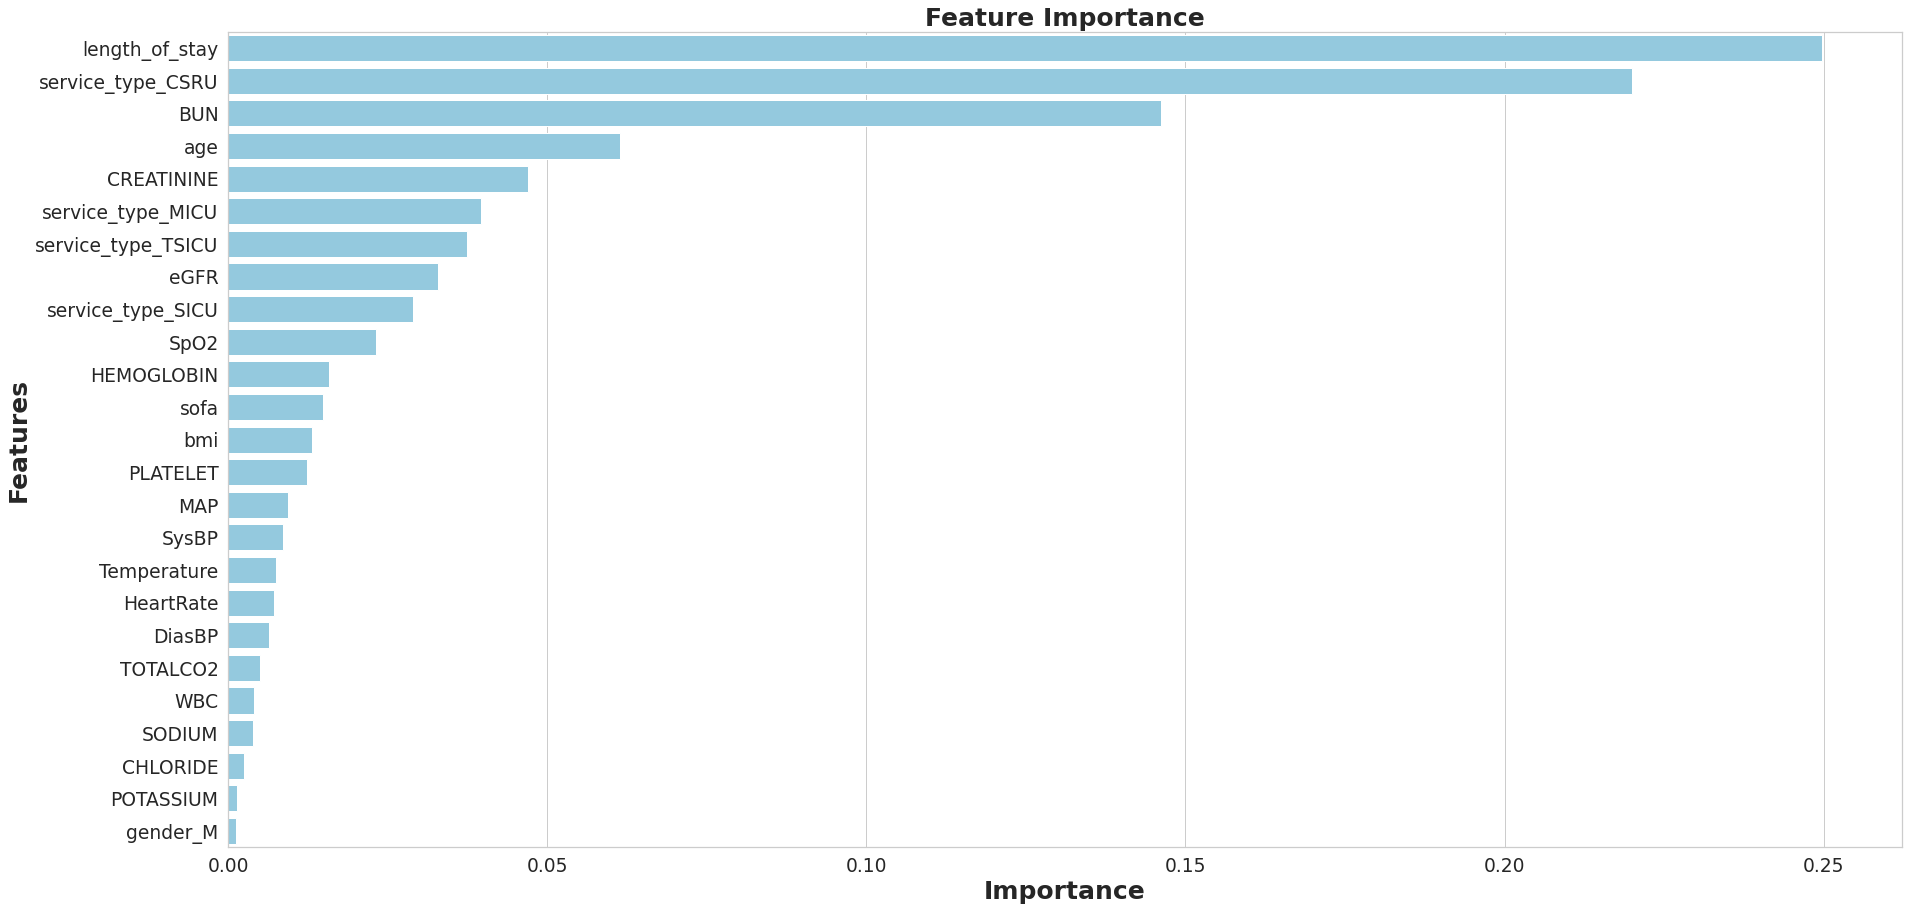

None

,Features,Gini-Importance
0,length_of_stay,0.249786
1,service_type_CSRU,0.219957
2,BUN,0.146235
3,age,0.061416
4,CREATININE,0.047030
5,service_type_MICU,0.039618
6,service_type_TSICU,0.037436
7,eGFR,0.032942
8,service_type_SICU,0.028953
9,SpO2,0.023242


In [10]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.5min finished


Test set score: 0.742 +/- 0.007
Recall: 0.616 +/- 0.023
AUC: 0.764 +/- 0.008


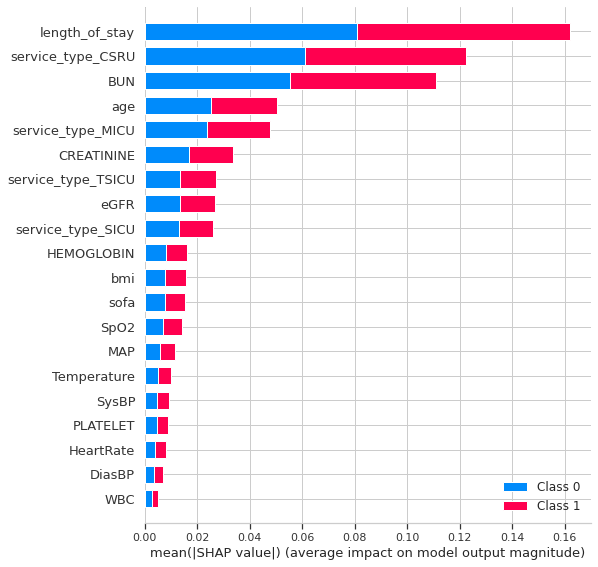

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, recall_score, confusion_matrix, roc_curve, auc
from statistics import mean, stdev
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
import shap

oversample = SMOTENC(categorical_features=[20, 21, 22, 23, 24])
testscore = []
recall = []
auc = []
class_0 = np.empty((0,25), float)

class_1 = np.empty((0,25), float)

n_estimators = [200]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(start = 2, stop = 5, num = 4)]
min_samples_split = [27,28,29]
min_samples_leaf = [2,3,4]
bootstrap = [False]

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

for i in range(30):
    # Split the data into train and test (75% - 25%)
    train_x, test_x, y_train, y_test = train_test_split(df_features,df_labels,test_size=0.25,random_state=i)

    # Preprocessing
    numerical_train_x = train_x[numerical_cols].reset_index(drop=True)
    categorical_train_x = pd.get_dummies(train_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
    X_train = pd.concat([numerical_train_x, categorical_train_x],axis=1)
    numerical_test_x = test_x[numerical_cols].reset_index(drop=True)
    categorical_test_x = pd.get_dummies(test_x[[var for var in categorical_cols]], drop_first = True).reset_index(drop=True)
    X_test = pd.concat([numerical_test_x, categorical_test_x],axis=1)

    # Modelling
    X, y = oversample.fit_resample(X_train, y_train)
    rfc = RandomForestClassifier()

    gs_rfc = GridSearchCV(rfc, param_dist, cv = 5, verbose = 1, n_jobs=-1)
    gs_rfc.fit(X, y)
    rfc_gs = gs_rfc.best_estimator_.fit(X, y)
    
    # coefficients
    explainer = shap.TreeExplainer(rfc_gs)
    shap_values = explainer.shap_values(X)
    class_0 = np.concatenate((class_0, shap_values[0]), axis = 0)
    class_1 = np.concatenate((class_1, shap_values[1]), axis = 0)
    
    # test_accuracy_base
    testscore.append(rfc_gs.score(X_test,y_test))
    y_true_base, y_pred_base = y_test , rfc_gs.predict(X_test)
    
    # recall_base 
    recall.append(recall_score(y_true_base, y_pred_base))
    
    probs_base = rfc_gs.predict_proba(X_test)
    preds_base = probs_base[:,1]
    fpr_base, tpr_base, threshold = metrics.roc_curve(y_true_base, preds_base)
    
    # roc_auc_base 
    auc.append(metrics.auc(fpr_base, tpr_base))

print("Test set score: {0:.3f} +/- {1:.3f}".format(mean(testscore), stdev(testscore)))
print("Recall: {0:.3f} +/- {1:.3f}".format(mean(recall), stdev(recall)))
print("AUC: {0:.3f} +/- {1:.3f}".format(mean(auc), stdev(auc)))

shap.summary_plot([class_0, class_1], X, plot_type="bar")